# Session 2: Analyzing Code Performance

### Topics
1. Timing Julia functions
2. Accurate benchmarking
3. Profiling Julia functions
4. (optional) Tracking detailed memory allocation

In [1]:
using Pkg;
Pkg.activate("."); #local environment
Pkg.add("BenchmarkTools");
Pkg.add("Plots");
Pkg.add("Profile");
Pkg.add("ProfileView")
Pkg.status();

  Activating environment at `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
  No Changes to `~/Documents/GitHub/Phys215-202122-1/02-Performance/Manifest.toml`


      Status `~/Documents/GitHub/Phys215-202122-1/02-Performance/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.0
  [91a5bcdd] Plots v1.22.3
  [c46f51b8] ProfileView v0.6.10
  [9abbd945] Profile


# Session 2 OKR
**OBJECTIVE**: Submit a performance analysis of a self-implemented physics textbook function or constant using Julia benchmarking tools.

- [ ] **KR1:** Implemented (customized) at least one math/physics textbook function, or constant (prefer those that involve a sum or a loop) in Julia. Discuss its importance in Physics. See Resources section.
- [ ] **KR2:** Compare the performance (accuracy) of the implemented function in comparison with the existing special functions within Julia.
- [ ] **KR3:** Successful loading of the `BenchmarkTools` module. May need to add it first via the `Pkg` or REPL package mode.
- [ ] **KR4:** Itemized differences between `@time`, `@btime`, `@benchmark` and other `@time`-like macros. Nice if the situations when they are best applied are mentioned.
- [ ] **KR5:** Identified demonstrated useful features within the `Profiler` module of Julia. Features must be explained why useful for your case.
- [ ] **KR6:** A discussion of the performance of the implemented function above.

# A review...

# The naive sum

One of the most common processes in numerical methods is doing a serial operation on a _list_ of values (say, a `Vector`).

Remember the **naive sum** we investigated before?

In [2]:
"""
    seql_sum(x)

A naive cumulative function.
Input: iterable container `x`
Output: sum of all elements of `x`
"""
function seql_sum(x)
    result = zero(eltype(x))
    for i in eachindex(x)
        result += x[i]
    end
    return result
end

seql_sum

**Notes**: 
- Doc string is added as a sample of documentation.
- The element type of the input variable `x`

# Artificial Data

In [3]:
N = 10_000_000;
x64 = rand(N); #Float32 type
x32 = rand(Float32,2*length(x64)); #same memory length

**Note:**
- `x32` and `x64` have the same memory length used in the RAM
- The underscore (`_`) is ignored by Julia (mentioned before).

# Testing `seql_sum()`

**Q:** What is the expected value of the sum of both `x64` and `x32`?

Since the random number is distributed uniformly over the interval $(0,1]$, we expect that the average is about '0.5N'.

In [4]:
x̄ = 0.5N

5.0e6

In [5]:
println("\nNOTES:");
println("> eps(eltype(x64)) is $(round(eps(eltype(x64)),digits=20)).");
Σtol = 1/sqrt(length(x64));
println("> Statistical tolerance is $(round(Σtol,digits=5)).");


NOTES:
> eps(eltype(x64)) is 2.2204e-16.
> Statistical tolerance is 0.00032.


In [6]:
Σx₀ = sum(x64);
println("Reference: sum(x64) is $(round(Σx₀,digits=5)).");
println("    Deviation from E[Σx]: |Δ| = $(round(abs(Σx₀-x̄),digits=2)).")

Reference: sum(x64) is 4.99808658293e6.
    Deviation from E[Σx]: |Δ| = 1913.42.


In [7]:
Σx = seql_sum(x64);
println("The relation: seql_sum(x64) ≈ sum(x64) is **$(Σx ≈ Σx₀)**");
println("    with |Δ|=$(round(abs(Σx-Σx₀),digits=10)).");
println("");
println("Note 1: Statistical tolerance Σtol is $(round(Σtol,digits=5)).");
println("Note 2: eps(eltype(x64)) is ϵ ≈ $(round(eps(eltype(x64)),digits=20)).");

The relation: seql_sum(x64) ≈ sum(x64) is **true**
    with |Δ|=6.715e-7.

Note 1: Statistical tolerance Σtol is 0.00032.
Note 2: eps(eltype(x64)) is ϵ ≈ 2.2204e-16.


👏 **So it works!**

# Session 2 OKR
**OBJECTIVE**: Submit a performance analysis of a self-implemented physics textbook function or constant using Julia benchmarking tools.

- [x] **KR1:** Implemented (customized) at least one math/physics textbook function, or constant (prefer those that involve a sum or a loop) in Julia. Discuss its importance in Physics. See Resources section.
- [x] **KR2:** Compare the performance (accuracy) of the implemented function in comparison with the existing special functions within Julia.
- [ ] **KR3:** Successful loading of the `BenchmarkTools` module. May need to add it first via the `Pkg` or REPL package mode.
- [ ] **KR4:** Itemized differences between `@time`, `@btime`, `@benchmark` and other `@time`-like macros. Nice if the situations when they are best applied are mentioned.
- [ ] **KR5:** Identified demonstrated useful features within the `Profiler` module of Julia. Features must be explained why useful for your case.
- [ ] **KR6:** A discussion of the performance of the implemented function above.

# Timing `seql_sum()`

There are several options for timing Julia functions.
From Julia `Base`, we have `@time` used in our previous Session. 
Its variants are `@timev` (`v`erbose) and `@timed` (`d`ata?).
Other options can also be used such as `@elapsed` and others.

In [8]:
base64 = @timed sum(x64);
base64 = @timed sum(x64);

base32 = @timed sum(x32);
base32 = @timed sum(x32);

typeof(base64)

NamedTuple{(:value, :time, :bytes, :gctime, :gcstats), Tuple{Float64, Float64, Int64, Float64, Base.GC_Diff}}

In [9]:
t64₀ = base64[:time];
t32₀ = base32[:time];
println("The time t64₀ for sum(x64) is $(t64₀).")
println("The time t32₀ for sum(x32) is $(t32₀)")
println("    such that t32₀/t64₀ = $(round(t32₀/t64₀,digits=5)).");

The time t64₀ for sum(x64) is 0.005036507.
The time t32₀ for sum(x32) is 0.00502248
    such that t32₀/t64₀ = 0.99721.


In [10]:
seql64 = @timed seql_sum(x64);
seql64 = @timed seql_sum(x64);

seql32 = @timed seql_sum(x32);
seql32 = @timed seql_sum(x32);

t64₁ = seql64[:time]
t32₁ = seql32[:time]
println("The time t64₁ for seql_sum(x64) is $(t64₁).")
println("The time t32₁ for seql_sum(x32) is $(t32₁)")
println("    such that t32₁/t64₁ = $(round(t32₁/t64₁,digits=5))");
println("              t64₁/t64₀ = $(round(t64₁/t64₀,digits=5))");
println("    and       t32₁/t32₀ = $(round(t32₁/t32₀,digits=5))");

The time t64₁ for seql_sum(x64) is 0.014088528.
The time t32₁ for seql_sum(x32) is 0.026260958
    such that t32₁/t64₁ = 1.864
              t64₁/t64₀ = 2.79728
    and       t32₁/t32₀ = 5.22868


The naive sum function takes more than about 2.5× (`Float64`) and about 4.5× (`Float32`) longer than the `Base.sum()` function!

These results however needs to be repeated several times to ensure statistically-significant interpretation.

# The `BenchmarkTools` module

This module provides a more statistically consistent test results.

The module provides the following macros.
- `@btime`
- `@benchmark`

In [11]:
using BenchmarkTools

In [12]:
?@btime

```
@btime expression [other parameters...]
```

Similar to the `@time` macro included with Julia, this executes an expression, printing the time it took to execute and the memory allocated before returning the value of the expression.

Unlike `@time`, it uses the `@benchmark` macro, and accepts all of the same additional parameters as `@benchmark`.  The printed time is the *minimum* elapsed time measured during the benchmark.


In [13]:
@btime seql_sum($x64)

  12.346 ms (0 allocations: 0 bytes)


4.998086582934245e6

- **NOTE**: It takes longer time to exexute the macro. Evaluation is done multiple times. Automatically calculates the appropriate number of samples.
- **NOTE**: The output `ans` is the return of the function being evaluated.
- **NOTE**: The `$()` function brings the evaluated variable into the function removing the allocation due to argument passing. This is only applicable for the `BenchmarkTools` macros.

In [14]:
?@benchmark

```
@benchmark <expr to benchmark> [setup=<setup expr>]
```

Run benchmark on a given expression.

# Example

The simplest usage of this macro is to put it in front of what you want to benchmark.

```julia-repl
julia> @benchmark sin(1)
BenchmarkTools.Trial:
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     13.610 ns (0.00% GC)
  median time:      13.622 ns (0.00% GC)
  mean time:        13.638 ns (0.00% GC)
  maximum time:     21.084 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998
```

You can interpolate values into `@benchmark` expressions:

```julia
# rand(1000) is executed for each evaluation
julia> @benchmark sum(rand(1000))
BenchmarkTools.Trial:
  memory estimate:  7.94 KiB
  allocs estimate:  1
  --------------
  minimum time:     1.566 μs (0.00% GC)
  median time:      2.135 μs (0.00% GC)
  mean time:        3.071 μs (25.06% GC)
  maximum time:     296.818 μs (95.91% GC)
  --------------
  samples:          10000
  evals/sample:     10

# rand(1000) is evaluated at definition time, and the resulting
# value is interpolated into the benchmark expression
julia> @benchmark sum($(rand(1000)))
BenchmarkTools.Trial:
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     101.627 ns (0.00% GC)
  median time:      101.909 ns (0.00% GC)
  mean time:        103.834 ns (0.00% GC)
  maximum time:     276.033 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     935
```


In [15]:
@btime seql_sum($x64)

  12.334 ms (0 allocations: 0 bytes)


4.998086582934245e6

In [16]:
bench = @benchmark seql_sum($x64)

BenchmarkTools.Trial: 382 samples with 1 evaluation.
 Range (min … max):  11.655 ms …  15.986 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.977 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.084 ms ± 628.828 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▃  ██▅▁▆▅▁▅▅▅ ▃ ▁  ▃▅▁                          
  ▃▁▁▃▃▅▃▃▃▃▁▆█▇█▆███████████▇█▄█▅████▆▃▇▆▃▃▆▃▄▃▃▄▃▃▅▃▃▆▃▁▁▃▁▃ ▄
  11.7 ms         Histogram: frequency by time         14.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

**NOTE**: The output is the benchmark result itself rather than the function return.

The `propertynames` of `bench::Benchmark.Trials`..

In [17]:
?propertynames

search: propertynames



```
propertynames(x, private=false)
```

Get a tuple or a vector of the properties (`x.property`) of an object `x`. This is typically the same as [`fieldnames(typeof(x))`](@ref), but types that overload [`getproperty`](@ref) should generally overload `propertynames` as well to get the properties of an instance of the type.

`propertynames(x)` may return only "public" property names that are part of the documented interface of `x`.   If you want it to also return "private" fieldnames intended for internal use, pass `true` for the optional second argument. REPL tab completion on `x.` shows only the `private=false` properties.


In [18]:
propertynames(bench) # == fieldnames(typeof(bench))

(:params, :times, :gctimes, :memory, :allocs)

In [19]:
bench

BenchmarkTools.Trial: 382 samples with 1 evaluation.
 Range (min … max):  11.655 ms …  15.986 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.977 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.084 ms ± 628.828 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▃  ██▅▁▆▅▁▅▅▅ ▃ ▁  ▃▅▁                          
  ▃▁▁▃▃▅▃▃▃▃▁▆█▇█▆███████████▇█▄█▅████▆▃▇▆▃▃▆▃▄▃▃▄▃▃▅▃▃▆▃▁▁▃▁▃ ▄
  11.7 ms         Histogram: frequency by time         14.9 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [20]:
bench.times

382-element Vector{Float64}:
 1.3114178e7
 1.3504834e7
 1.3463592e7
 1.3483072e7
 1.3264754e7
 1.339389e7
 1.3496605e7
 1.3489609e7
 1.3527356e7
 1.3498153e7
 1.3461779e7
 1.346395e7
 1.3601947e7
 ⋮
 1.2546734e7
 1.2856784e7
 1.3082069e7
 1.2960146e7
 1.2999245e7
 1.2442406e7
 1.2434764e7
 1.2264404e7
 1.249849e7
 1.2506546e7
 1.2880033e7
 1.302075e7

# Session 2 OKR
**OBJECTIVE**: Submit a performance analysis of a self-implemented physics textbook function or constant using Julia benchmarking tools.

- [x] **KR1:** Implemented (customized) at least one math/physics textbook function, or constant (prefer those that involve a sum or a loop) in Julia. Discuss its importance in Physics. See Resources section.
- [x] **KR2:** Compare the performance (accuracy) of the implemented function in comparison with the existing special functions within Julia.
- [x] **KR3:** Successful loading of the `BenchmarkTools` module. May need to add it first via the `Pkg` or REPL package mode.
- [x] **KR4:** Itemized differences between `@time`, `@btime`, `@benchmark` and other `@time`-like macros. Nice if the situations when they are best applied are mentioned.
- [ ] **KR5:** Identified demonstrated useful features within the `Profiler` module of Julia. Features must be explained why useful for your case.
- [ ] **KR6:** A discussion of the performance of the implemented function above.

# A mechanics ODE problem

A mechanics textbook shows a dynamical system with the following equation of motion.

$$ẍ = 2ω₀x\left[ 1 -  \frac{1}{\sqrt{1+x^2}}\right]$$

The computational solution will always require the evaluation of the resulting rate function since solutions are always in the following first-order ODE:

$$ṡ = f(s,t)$$

since most techniques are based on the *Euler method* providing the step size $δs$ for a given time step $δt$ such that

$$δs = ṡ \times δt.$$

Most ODE solvers requires the knowledge of the function $f(s,t)$, the initial value $s₀$ and the span of time where the variable $t$ will run.
The function $f(s,t)$ will be called many many times by the algorithm.

It is therefore important that the function $f(s,t)$ be made as efficient as possible.

## Conversion to 1st order ODE
From
$$\ddot{x} = 2 \omega^2_0 x\left[ 1 -  \frac{1}{\sqrt{1+x^2}}\right]$$
and letting $v = ẋ$, we can represent the state of the system as a vector $\mathbf{s}$ such that

$$s_1 = x$$
$$s_2 = v$$

Resulting to the following 1st order vector ODE:

$$\dot{\mathbf{s}} = \mathbf{f}(\mathbf{s},t)$$

In [21]:
s = [ 0.1   # holds x
      0.0 ] # holds v

2-element Vector{Float64}:
 0.1
 0.0

... assigning `s[1]` as $x$ and assign `s[2]` as $v$.

# Implementing the derivative function
We define a function `sdot(s,t; ω₀)` as $f(s,t)$ such that the *named parameter* `ω₀` can be used as the parameter of our model.
We can give it a default value `ω₀=1.0` (a `Float64`).

The standard format of many ODE solvers uses a parameter `Vector` or `Tuple` `p` such that the usual format in ODE solvers must be:
```
f(u,t,p)
```
This form is advantageous for analyzing the parameter changes.

Here, we will just use our simpler and quickest form...

In [22]:
"""
    sdot(s,t; ω₀ = 1.0)

Returns the `ṡ` vector given `s` and time `t`.
"""
sdot(s,t; ω₀ = 1.0) = [ s[2]
               -2.0*ω₀*ω₀*s[1]*( 1.0 - 1.0 / sqrt(1.0 + s[1]*s[1]) ) ]

sdot

In [23]:
s = [1.0, 0.0]
ṡ = sdot(s,0.0)

2-element Vector{Float64}:
  0.0
 -0.5857864376269051

# Benchmarking calls to `sdot(s,t; ω₀)`

In [24]:
using BenchmarkTools

We need to simulate a function call of at least a few hundred thousands just to get statistically significant timings similar to the actual practice..

In [25]:
bench = @benchmark for _ in 1:1_000_000 ṡ = sdot($s,$0.0) end

BenchmarkTools.Trial: 101 samples with 1 evaluation.
 Range (min … max):  43.170 ms … 56.705 ms  ┊ GC (min … max): 17.16% … 16.52%
 Time  (median):     49.710 ms              ┊ GC (median):    16.57%
 Time  (mean ± σ):   49.611 ms ±  2.987 ms  ┊ GC (mean ± σ):  16.58% ±  0.70%

                    ▂       ▄      ▄  ▂   █ ▄                  
  ▄▄▁█▁▁▄▁▄▆█▄▄▁█▄▆▄█▄▆███▆██▄▆▄▆▄▁█▄▆██▄██▆██▆█▄▁▁▁▄▁▁▁▄▁▁▄▄ ▄
  43.2 ms         Histogram: frequency by time        56.1 ms <

 Memory estimate: 91.55 MiB, allocs estimate: 1000000.

# Alternative : utilize passing by reference

In Julia, those objects passed into functions and gets modified require that the function name end with a `bang` (`!`) suffix.

In [26]:
"""
    get_sdot!(ṡ, s, t; ω₀ = 1.0)

Computes the new `ṡ`-values, given the dynamical system state `s` at time `t`.
"""
function get_sdot!(ṡ, s, t; ω₀ = 1.0)
    x = s[1];
    v = s[2];
    ṡ[1] = v;
    ṡ[2] = -2.0*ω₀*ω₀*x*( 1.0 - 1.0 / sqrt(1.0 + x*x) )
    return nothing #optional line.. same effect if not present.
end

get_sdot!

- **NOTE**: No call for the `pointers` `ṡ` and `s` inside the function.
- **NOTE**: The function `return`s `nothing`.

## Let's test `get_sdot!()`

In [27]:
s = [ 1.0, 0.0 ];
ṡ₁ = zero(s);
get_sdot!(ṡ₁, s, 0.0);
ṡ₁

2-element Vector{Float64}:
  0.0
 -0.5857864376269051

In [28]:
ṡ₁ == ṡ

true

## .. and the benchmark

In [29]:
s = [ 1.0, 0.0 ];
ṡ = zero(s);
bench₁ = @benchmark for _ in 1:1_000_000 get_sdot!(ṡ,s,0.0) end

BenchmarkTools.Trial: 292 samples with 1 evaluation.
 Range (min … max):  13.187 ms … 56.931 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.871 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.158 ms ±  4.067 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂     ▃ ▄▃█▆▁                                              
  ▅██▇██▇▇███████▃▅▅▃▃▄▂▃▂▃▂▁▂▂▁▁▁▁▃▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂ ▃
  13.2 ms         Histogram: frequency by time        33.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

## Comparison of `bench` and `bench₁`

In [30]:
bench #using sdot(s,t;ω₀)

BenchmarkTools.Trial: 101 samples with 1 evaluation.
 Range (min … max):  43.170 ms … 56.705 ms  ┊ GC (min … max): 17.16% … 16.52%
 Time  (median):     49.710 ms              ┊ GC (median):    16.57%
 Time  (mean ± σ):   49.611 ms ±  2.987 ms  ┊ GC (mean ± σ):  16.58% ±  0.70%

                    ▂       ▄      ▄  ▂   █ ▄                  
  ▄▄▁█▁▁▄▁▄▆█▄▄▁█▄▆▄█▄▆███▆██▄▆▄▆▄▁█▄▆██▄██▆██▆█▄▁▁▁▄▁▁▁▄▁▁▄▄ ▄
  43.2 ms         Histogram: frequency by time        56.1 ms <

 Memory estimate: 91.55 MiB, allocs estimate: 1000000.

In [31]:
bench₁ #using get_sdot!(ṡ,s,t;ω₀)

BenchmarkTools.Trial: 292 samples with 1 evaluation.
 Range (min … max):  13.187 ms … 56.931 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.871 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.158 ms ±  4.067 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂     ▃ ▄▃█▆▁                                              
  ▅██▇██▇▇███████▃▅▅▃▃▄▂▃▂▃▂▁▂▂▁▁▁▁▃▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂ ▃
  13.2 ms         Histogram: frequency by time        33.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [32]:
println("The function get_sdot!() is faster than sdot() by a factor of:")
println("    ∼ $(round(median(bench.times)/median(bench₁.times),digits=1))×!")

The function get_sdot!() is faster than sdot() by a factor of:
    ∼ 2.9×!


## The Euler method

After having discretized time as $t \in \{t_0, t_1, \ldots, t_n, \ldots\}$ resulting to values of $s \in \{s_0, s_1, \ldots, s_n, \ldots\}$, is as follows.

We solve for the state variable step $\delta s$ as
$$\delta s_n = \delta t \cdot f(s_n,t_n; \omega_0)$$
and obtain values at the next step $n+1$ as
$$s_{n+1} = s_n + \delta s_n$$
and
$$t_{n+1} = t_n + \delta t.$$

In [33]:
?get_sdot!

search: get_sdot!



```
get_sdot!(ṡ, s, t; ω₀ = 1.0)
```

Computes the new `ṡ`-values, given the dynamical system state `s` at time `t`.


## Testing the one Euler step

In [34]:
s = [1.0, 0.0];
ṡ = zero(s);
t = 0.0; #as holder for now
δt = 0.01;

In [35]:
println("s($(t)) = $(s).")
get_sdot!(ṡ,s,t);
s = s + δt * ṡ;
t = t + δt
println("s($(t)) = $(s).")

s(0.0) = [1.0, 0.0].
s(0.01) = [1.0, -0.005857864376269051].


# A full Euler [quick and dirty] implementation

In [36]:
"""
    euler!(sdata, trange, s0; ω₀ = 1.0)

Computes for the series of values of states `sdata` over different time points `tdata`.
- Requires: Function `get_sdot!()`
- Returns modified: `sdata::2×length(tdata) Matrix{Float64}`
- Input: `s0::Vector{Float64}` = initial state
-        `trange` = iterable range of time values (assumed `Float64`)
"""
function euler!(sdata, tdata, s0; ω₀ = 1.0)
    δt = tdata[2]-tdata[1];
    #we wish to use existing memory
    #for s in sdata << don't use this one
    ṡ = copy(s0); #..just to allocate same size() //or dimension
    s = copy(s0);
    sdata[:,1] = s;
    for i in 2:size(sdata)[2]
        get_sdot!(ṡ,s,tdata[i], ω₀=ω₀) #..first ṡ gets modified anyway
        s = s + δt * ṡ
        sdata[:,i] = s
    end
end

euler!

## Initialization

In [37]:
tdata = range(0.0,100.0,length=5001);
sdata = zeros(2,length(tdata))
println("size(tdata) = $(size(tdata))")
println("size(sdata) = $(size(sdata))")
println(" stepsize = $(tdata[2]-tdata[1]).")

size(tdata) = (5001,)
size(sdata) = (2, 5001)
 stepsize = 0.02.


## Sample run..

In [38]:
sdata

2×5001 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [39]:
euler!(sdata,tdata,[0.2,0.0])

In [40]:
sdata

2×5001 Matrix{Float64}:
 0.2   0.2           0.199997     …  -0.0610758  -0.0604927  -0.0599094
 0.0  -0.000155355  -0.000310709      0.0291581   0.0291627   0.0291671

## Plotting results..

In [41]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [42]:
function plot_them(sdata,tdata)
    plt = plot(tdata, sdata[1,:]
        ,label="position"
        ,linecolor=:green
    )
    
    plot!(plt, tdata, sdata[2,:]
        ,label="velocity"
        ,linecolor=:maroon
    )
    
    plot!(plt
        ,xaxis="time"
        ,yaxis="values"
        ,legend=:bottomright
    )
    
    display(plt);
end

plot_them (generic function with 1 method)

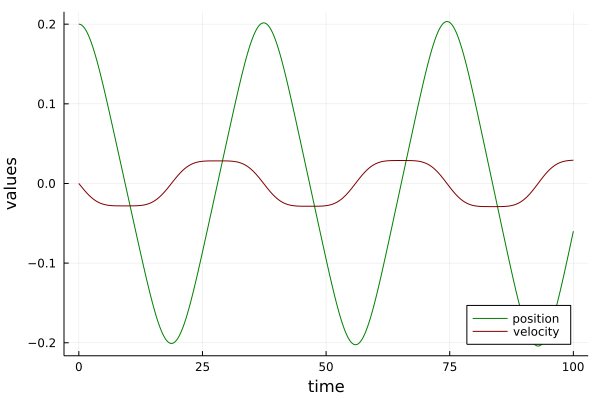

In [43]:
plot_them(sdata,tdata)

## Curious: What about higher initial amplitude?

In [44]:
tdata = range(0.0,100.0,length=5001);
sdata = zeros(2,length(tdata))
println("size(tdata) = $(size(tdata))")
println("size(sdata) = $(size(sdata))")
println(" stepsize = $(tdata[2]-tdata[1]).")

size(tdata) = (5001,)
size(sdata) = (2, 5001)
 stepsize = 0.02.


In [45]:
euler!(sdata,tdata,[1.0,0.0])

In [46]:
sdata

2×5001 Matrix{Float64}:
 1.0   1.0         0.999766    0.999297   …  -1.56821   -1.57921   -1.58964
 0.0  -0.0117157  -0.0234315  -0.0351411     -0.550218  -0.521216  -0.491842

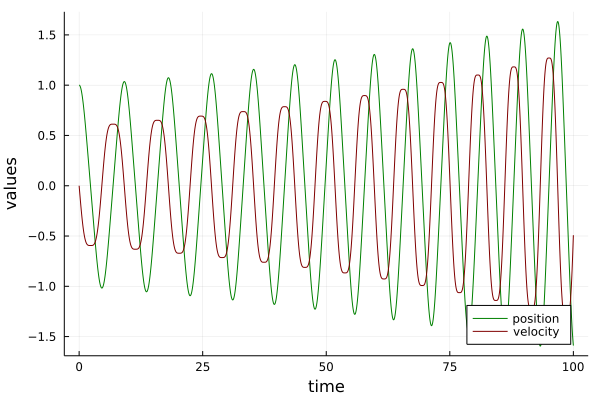

In [47]:
plot_them(sdata,tdata)

- **NOTE:** Both position and velocity start to diverge. => Euler is known to be unstable for stiff ODEs.

# Profiling

In [48]:
using Profile
using ProfileView

In [49]:
tdata = range(0.0,100.0,length=5001);
sdata = zeros(2,length(tdata))
println("size(tdata) = $(size(tdata))")
println("size(sdata) = $(size(sdata))")
println(" stepsize = $(tdata[2]-tdata[1]).")

size(tdata) = (5001,)
size(sdata) = (2, 5001)
 stepsize = 0.02.


## Good number of sampling

The `@profile`r requires a good number of samples of the calls.
Efficient codes may require multiple implementations in order to obtain a good profile view of the execution.

In our case, experimentation of the profiler concluded with the practical numbers used below.

In [50]:
@profile for _ in 1:20_000 euler!(sdata,tdata,[1.0,0.0]) end

ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged thread.
ERROR: Exception handler triggered on unmanaged 

- **NOTE**: The code returns as normal (as long as repetition does not _damage_ the result.

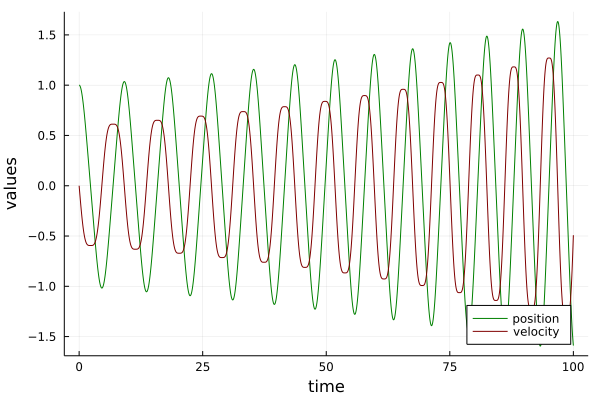

In [51]:
plot_them(sdata,tdata)

In [52]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
  40╎40    @Base/arraymath.jl:52; *(A::Float64, B::Vector{Float64})
  43╎43    ...multidimensional.jl:906; _unsafe_setindex!(::IndexLinea...
  27╎27    ...multidimensional.jl:918; _unsafe_setindex!(::IndexLinea...
    ╎8377  @Base/task.jl:411; (::IJulia.var"#15#18")()
    ╎ 8377  ...ia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
    ╎  8377  @Base/essentials.jl:706; invokelatest
    ╎   8377  @Base/essentials.jl:708; #invokelatest#2
    ╎    8377  ...execute_request.jl:67; execute_request(socket::ZMQ....
    ╎     8377  ...oftGlobalScope.jl:65; softscope_include_string(m::...
    ╎    ╎ 8377  @Base/loading.jl:1116; include_string(mapexpr::ty...
    ╎    ╎  8377  @Base/boot.jl:360; eval
    ╎    ╎   8377  ...e/src/Profile.jl:28; top-level scope
   1╎    ╎    1     In[50]:0; macro expansion
   3╎    ╎    8376  In[50]:1; macro expansion
  21╎    ╎     8371  In[36]:11; euler!(sdata::Matrix{Flo...
   1╎    ╎    ╎ 1     In[26]:1

    ╎    ╎    ╎    ╎    ╎ 23    ...roadcast.jl:964; preprocess
   1╎    ╎    ╎    ╎    ╎  23    ...oadcast.jl:957; broadcast_unalias
    ╎    ╎    ╎    ╎    ╎   22    ...tarray.jl:1349; unalias
  20╎    ╎    ╎    ╎    ╎    22    ...tarray.jl:1384; mightalias
    ╎    ╎    ╎    ╎    ╎     2     ...tarray.jl:1408; dataids
    ╎    ╎    ╎    ╎    ╎    ╎ 2     ...tarray.jl:1116; pointer
   2╎    ╎    ╎    ╎    ╎    ╎  2     ...ointer.jl:65; unsafe_convert
    ╎    ╎    ╎    ╎  234   ...broadcast.jl:983; copyto!
   2╎    ╎    ╎    ╎   2     .../simdloop.jl:0; macro expansion
    ╎    ╎    ╎    ╎   2     .../simdloop.jl:72; macro expansion
   2╎    ╎    ╎    ╎    2     @Base/int.jl:83; <
    ╎    ╎    ╎    ╎   140   .../simdloop.jl:77; macro expansion
    ╎    ╎    ╎    ╎    140   ...roadcast.jl:984; macro expansion
  83╎    ╎    ╎    ╎     83    @Base/array.jl:843; setindex!
    ╎    ╎    ╎    ╎     57    ...roadcast.jl:575; getindex
    ╎    ╎    ╎    ╎    ╎ 50    ...roadcast.jl:620; _broa

In [53]:
ProfileView.view()

Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip-taskbar-hint

# ProfileView docs excerpts

[`ProfileView.jl`](https://github.com/timholy/ProfileView.jl) contains documentation on how to interpret the FlameGraph produced by `ProfileView.view()` function.

> The horizontal axis represents the amount of time (more precisely, the number of backtraces) spent at each line. The row at which the single long bar breaks up into multiple different-colored bars corresponds to the execution of different lines from profile_test. The fact that they are all positioned on top of the lower peach-colored bar means that all of these lines are called by the same "parent" function. Within a block of code, they are sorted in order of increasing line number, to make it easier for you to compare to the source code.

And the colors?

> It is also worth noting that red is (by default) a special color: it is reserved for function calls that have to be resolved at run-time. Because run-time dispatch (aka, dynamic dispatch, run-time method lookup, or a virtual call) often has a significant impact on performance, ProfileView highlights the problematic call in red. It's worth noting that some red is unavoidable; for example, the REPL can't predict in advance the return types from what users type at the prompt, and so the bottom eval call is red. Red bars are problematic only when they account for a sizable fraction of the top of a call stack, as only in such cases are they likely to be the source of a significant performance bottleneck. 

# Session 2 OKR
**OBJECTIVE**: Submit a performance analysis of a self-implemented physics textbook function or constant using Julia benchmarking tools.

- [x] **KR1:** Implemented (customized) at least one math/physics textbook function, or constant (prefer those that involve a sum or a loop) in Julia. Discuss its importance in Physics. See Resources section.
- [x] **KR2:** Compare the performance (accuracy) of the implemented function in comparison with the existing special functions within Julia.
- [x] **KR3:** Successful loading of the `BenchmarkTools` module. May need to add it first via the `Pkg` or REPL package mode.
- [x] **KR4:** Itemized differences between `@time`, `@btime`, `@benchmark` and other `@time`-like macros. Nice if the situations when they are best applied are mentioned.
- [x] **KR5:** Identified demonstrated useful features within the `Profiler` module of Julia. Features must be explained why useful for your case.
- [x] **KR6:** A discussion of the performance of the implemented function above.

# Fin. [Back.](https://jybantang.github.io/Phys215-202122-1/02-Performance/)

In [54]:
function test!(sdata)
    for i in 1:size(sdata)[2]
        sdata[:,i] = [1.0, 1.0]
    end
end

test! (generic function with 1 method)

In [55]:
tdata[501]

10.0

In [56]:
sdata

2×5001 Matrix{Float64}:
 1.0   1.0         0.999766    0.999297   …  -1.56821   -1.57921   -1.58964
 0.0  -0.0117157  -0.0234315  -0.0351411     -0.550218  -0.521216  -0.491842

In [57]:
test!(sdata)

In [58]:
sdata

2×5001 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [59]:
sdata[:,1]

2-element Vector{Float64}:
 1.0
 1.0